In [386]:
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Softmax, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
import tensorflow as tf
import datetime
import tensorboard
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import numpy as np
from imblearn.over_sampling import SMOTE


#array de colunas


In [387]:
weeks1 = pd.read_csv('../data_raw/dados/2016-1/tabela processada nota media mediana iteracao.csv')
features = ['Aprovado']

for i in range(18):
  features.append(f'Week{i}')
  features.append(f'MedianaW{i}')
  features.append(f'MediaW{i}')
how = ['first']

for i in range(18*3):
  how.append(f'last')

dict_agg = dict(zip(features,how))

weeks2_semnotas = pd.read_csv('../data_raw/dados/2016-2/tabela final .csv')
weeks2_comnotas = pd.read_csv('../data_raw/dados/2016-2/tabela de iteracoes com nota add.csv')
#weeks2 = weeks2_semnotas.join(weeks2_comnotas,on='Nome',how='inner')
weeks2_raw = pd.concat([weeks2_semnotas, weeks2_comnotas])
weeks2 = weeks2_raw.groupby(weeks2_raw['Nome']).agg(dict_agg)
weeks2.dropna(inplace=True)
weeks3 = pd.read_csv('../data_raw/dados/2017-1/tabela final.csv')
weeks4 = pd.read_csv('../data_raw/dados/2017-2/tabela com media mediana e interacao e nota.csv')

weeks_raw =  [weeks1, weeks2, weeks3, weeks4]


In [388]:
def weeks_formating(weeks):
  
  weeks.fillna(0, inplace=True)
  weeks.drop(['Unnamed: 0.1','Notas', 'Unnamed: 0', 'Nome'], inplace=True, axis=1, errors='ignore')
  weeks['Aprovado'] = pd.Categorical(weeks['Aprovado'])
  weeks['Aprovado'] = weeks.Aprovado.cat.codes
  weeks = (weeks
          .replace('\$\s+','', regex=True)
          .astype(float)
          .applymap('{:.2f}'.format))
  weeks = weeks.astype(float)
  weeks_lbl = weeks['Aprovado']
  count_zero = (weeks['Aprovado'] == 0).sum()
  count_one = (weeks['Aprovado'] == 1).sum()
  print(count_zero, count_one)
  return weeks, weeks_lbl

In [389]:
def oversample_data(X_train, y_train):
  smote = SMOTE(k_neighbors=3)
  X_oversample, y_oversample = smote.fit_resample(X_train, y_train)
  return X_oversample, y_oversample

In [390]:
def weeks_data(data, weeks_num):

  features = []

  for i in range(weeks_num):
    features.append(f'Week{i}')
    features.append(f'MedianaW{i}')
    features.append(f'MediaW{i}')

  weeks = data.loc[:,features]
  weeks = weeks.to_numpy()
  return weeks

In [391]:
def build_model(weeks_num):
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model = Sequential()
    model.add(LSTM(30, input_shape=(weeks_num, 3)))
    model.add(Dense(1, activation='sigmoid'))
    #model.add(Softmax(1))
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=["accuracy"])
    return model


In [392]:
weeks_auc = list()
weeks_num = 8
weeks_num_lst = list(range(0,weeks_num))
semester_lst = list()


In [393]:

for week in weeks_raw:
  weeks, label = weeks_formating(week)
  
  weeks_auc = list()

  X, y = oversample_data(weeks, label)
  for i in range(weeks_num):

    X_i = weeks_data(X, i+1)
    X_train, X_test, y_train, y_test = train_test_split(X_i, y, test_size=0.3)
    X_train = X_train.reshape(len(X_train), i+1, 3)
    X_test = X_test.reshape(len(X_test), i+1, 3)

    model = build_model(i+1)

    model.fit(x=X_train,
            y=y_train,
            batch_size=3,  
            epochs=5, 
            verbose=0)

    y_pred_keras = model.predict(X_test, verbose=0)
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
    auc_keras = auc(fpr_keras, tpr_keras)
    weeks_auc.append(auc_keras)
  semester_lst.append(weeks_auc)

7 22
6 18
10 27
12 20


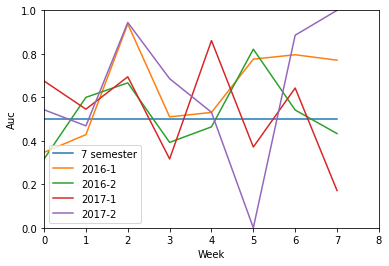

In [394]:
semester_dict = {0:'2016-1', 1:'2016-2', 2:'2017-1', 3:'2017-2'}
plt.plot(weeks_num_lst, [0.5]*weeks_num, label=str(i)+' semester')

for j in range(4):
  plt.plot(weeks_num_lst, semester_lst[j], label=semester_dict[j])
plt.xlabel('Week')
plt.ylabel('Auc')
plt.ylim(0, 1)
plt.xlim(0,weeks_num)
plt.legend()
plt.show()